In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import ta
from dataclasses import dataclass

plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'black'

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

In [41]:
data = pd.read_csv('Data/aapl_5m_train.csv').drop(columns=['Unnamed: 0', 'Timestamp', 'Gmtoffset']).dropna()

rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=15)
data['rsi'] = rsi_indicator.rsi()

rsi_down = 20
rsi_up = 80
data['buy_signal'] = data['rsi'] < rsi_down
data['sell_signal'] = data['rsi'] > rsi_up

data = data.dropna().reset_index(drop=True)
data.head()

,Datetime,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
0,2021-01-04 15:40:00,131.111297,131.309997,131.029998,131.044998,1253385.0,35.472015,False,False
1,2021-01-04 15:45:00,131.044006,131.044006,130.479995,130.749893,1730254.0,31.779676,False,False
2,2021-01-04 15:50:00,130.750000,130.830001,130.449996,130.709793,1887654.0,31.305254,False,False
3,2021-01-04 15:55:00,130.700103,131.250000,130.699996,131.000000,1608419.0,38.432075,False,False
4,2021-01-04 16:00:00,131.134994,131.309997,130.160003,130.309997,2055970.0,30.398179,False,False


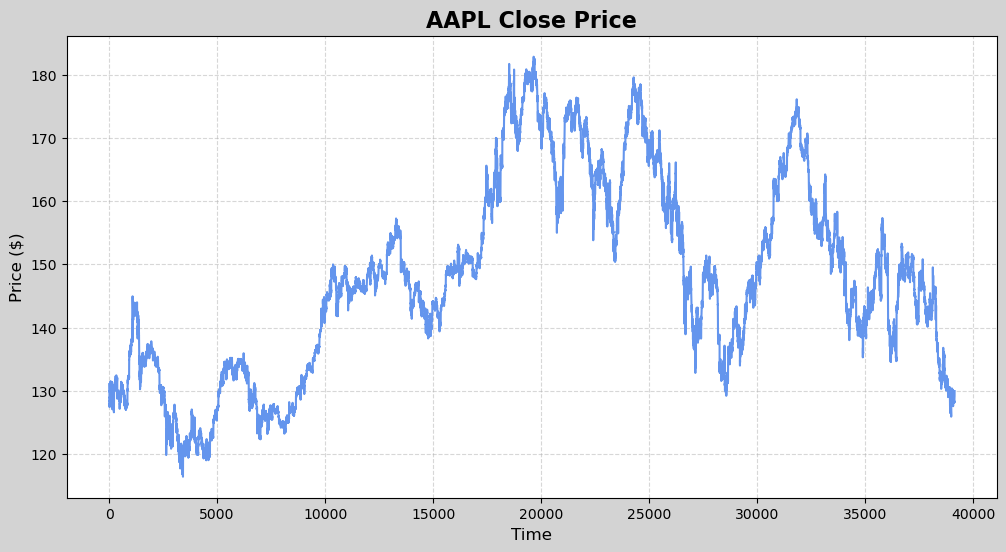

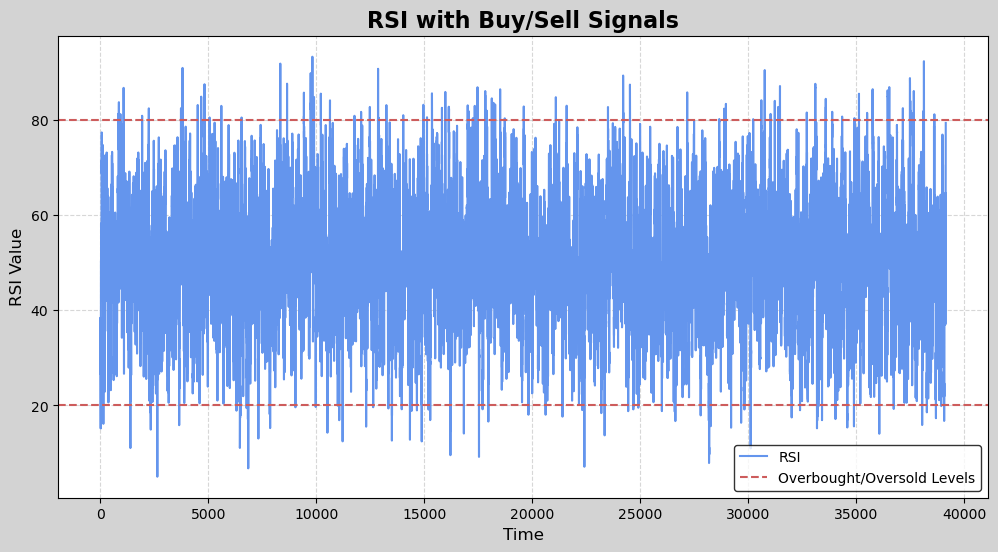

In [42]:
plt.figure()
plt.plot(data.Close, color = colors[0])
plt.title('AAPL Close Price')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.show()

plt.figure()
plt.plot(data.rsi, color = colors[0], label='RSI')
plt.axhline(rsi_down, color = colors[1], linestyle='--')
plt.axhline(rsi_up, color = colors[1], linestyle='--', label='Overbought/Oversold Levels')
plt.title('RSI with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('RSI Value')
plt.legend()
plt.show()

- Comisiones = 0.125%
- No hay Impuestos
- Margin Account = 50% 
- $ 1,000,000 USD Cash
- N Shares = 50
- Stop Loss, Take Profit = 6%
- Buy/Sell at close
- Borrow Rate = 0.25%

In [43]:
COM = 0.125 / 100
BORROW_RATE = 0.25 / 100
ADJUSTED_BORROW_RATE = BORROW_RATE / (252 * 6.5 * 60 / 5)

# DOF
STOP_LOSS = 0.1
TAKE_PROFIT = 0.1
N_SHARES = 50

INITIAL_MARGIN = 0.5
MANTEINANCE_MARGIN = 0.25

capital = 1_000_000
margin_account = 0

portfolio_value = [capital]

active_long_positions  = []
active_short_positions = []

In [44]:
@dataclass
class Position:
    """
    Data class for a trading position
    """
    ticker: str               # Ticker symbol
    n_shares: int             # Number of shares
    price: float              # Entry price
    time: str                 # Time position was opened
    sl: float                 # Stop loss level
    tp: float                 # Take profit level
    position_type: str        # 'long' or 'short'
    margin_account: float     # Margin account balance at position opening; 0 if long
    margin_requirement: float # Margin requirement for the position; 0 if long

# Function to calculate portfolio value
def get_portfolio_value(capital, long_positions, short_positions, current_price, n_shares):
    # Long positions are valued at current market price
    value = capital
    value += len(long_positions) * n_shares * current_price
    # Short positions are valued based on the margin account, margin requirement, and cost to buy to cover
    for position in short_positions:
        buy_to_cover_cost = current_price * position.n_shares * (1 + COM)
        value += position.margin_account + position.margin_requirement - buy_to_cover_cost

    return value

In [ ]:
for i, row in data.iterrows():
    # === CHECK ACTIVE ORDERS === #

    # --- LONG --- #
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profit / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            # Remove position from active pos
            active_long_positions.remove(position)
            continue 

    # --- SHORT --- #
    for position in active_short_positions.copy():
        # Discount borrow cost for active ahort positions
        buy_to_cover_cost = row.Close * position.n_shares * (1 + COM)
        position.margin_account -= row.Close * position.n_shares * ADJUSTED_BORROW_RATE

        # Short position status
        required_equity = buy_to_cover_cost * MANTEINANCE_MARGIN
        equity = position.margin_account + position.margin_requirement - buy_to_cover_cost

        # Margin call check
        if equity < required_equity:
            # Calculate margin call value
            margin_call = required_equity - equity
            # Print margin call info
            print(f'=== MARGIN CALL INFO ===\n' +
                  f'Margin call for {position.ticker} at {row.Datetime}\n' +
                  f'Equity required: ${required_equity:,.2f}\n' +
                  f'Equity available: ${equity:,.2f}\n' +
                  f'Margin call: ${margin_call:,.2f}\n' +
                   '======================== \n')
            # Update margin account
            position.margin_account += margin_call
            
            # Discount margin call from capital if available, else close position
            if capital > margin_call:
                capital -= margin_call
            else:
                capital += position.margin_account + position.margin_requirement - buy_to_cover_cost
                active_short_positions.remove(position) 
                continue

        # Check stop loss or take profit if not margin call
        else:
            # Stop loss or take profit check
            if row.Close < position.tp or row.Close > position.sl:
                # Add profit / losses to capital
                capital += position.margin_account + position.margin_requirement - buy_to_cover_cost
                # Remove position from active pos
                active_short_positions.remove(position)
                continue


    # === CHECK NEW SIGNALS === #

    # --- LONG --- #
    if row.buy_signal:
        cost = row.Close * N_SHARES * (1 + COM)
        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker             = 'AAPL', 
                           n_shares           = N_SHARES, 
                           price              = row.Close, 
                           time               = row.Datetime,
                           sl                 = row.Close * (1 - STOP_LOSS), 
                           tp                 = row.Close * (1 + TAKE_PROFIT),
                           position_type      = 'long', 
                           margin_account     = 0, 
                           margin_requirement = 0)
            active_long_positions.append(pos)
            continue 

    # --- SHORT --- #
    if row.sell_signal:
        required_margin = row.Close * N_SHARES * INITIAL_MARGIN
        # Do we have enough cash?
        if capital > required_margin:
            # Define margin account
            margin_account = row.Close * N_SHARES * (1 - COM)
            # Discount cash
            capital -= required_margin
            # Add position to portfolio
            pos = Position(ticker             = 'AAPL', 
                           n_shares           = N_SHARES, 
                           price              = row.Close, 
                           time               = row.Datetime,
                           sl                 = row.Close * (1 + STOP_LOSS), 
                           tp                 = row.Close * (1 - TAKE_PROFIT),
                           position_type      = 'short', 
                           margin_account     = margin_account, 
                           margin_requirement = required_margin)
            active_short_positions.append(pos)

    # Calculate portfolio value at the end of the iteration
    portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES))

# At the end of the backtesting, we should close all active positions
# --- LONG ---
capital += row.Close * len(active_long_positions)  * N_SHARES * (1 - COM)
active_long_positions  = []

# --- SHORT ---
for position in active_short_positions:
    buy_to_cover_cost = row.Close * position.n_shares * (1 + COM)
    capital += position.margin_account + position.margin_requirement - buy_to_cover_cost
active_short_positions = []

$2,216,326.46


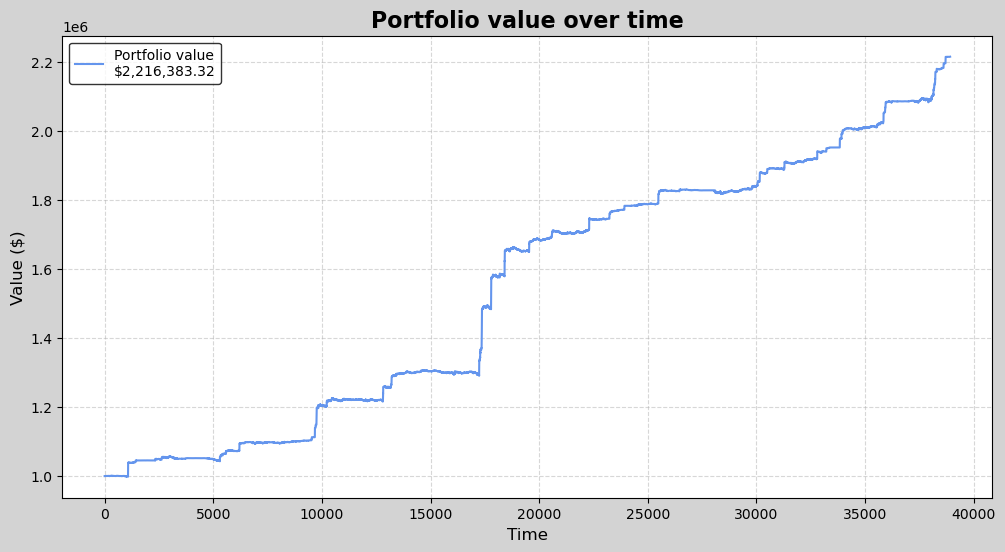

In [46]:
plt.figure()
plt.plot(portfolio_value, color=colors[0], label=f'Portfolio value\n${portfolio_value[-1]:,.2f}')
plt.title('Portfolio value over time')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.legend()
plt.show()